# A toy model for the Lazy Training
-----------------------------------

In this notebook, we show a simple application of the analytical learning method presented in the paper. Unlike the case studied in the paper, which focused on the extraction of Parton Distribution Functions (PDFs) from experimental data, here we follow a simplified model where no physics is actually involved. Hence, we will not introduce fast-kernel (FK) tables, the the evolution of the training process is uniquely driven by the NTK.

In [1]:
# Import
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)



from dlt.model import PDFmodel, generate_mse_loss

In [2]:
# Initialise numpy random seed
seed = 1241489141
np.random.seed(seed)

In this example, we use a simple function which will serve as underlying model that we ought to learn. Specifically, we choose the third Legendre polynomial from which we sample our data.

In [3]:
Ndat = 100
x_range = [-1,1]
test_function = scipy.special.legendre(3)
add_noise = False

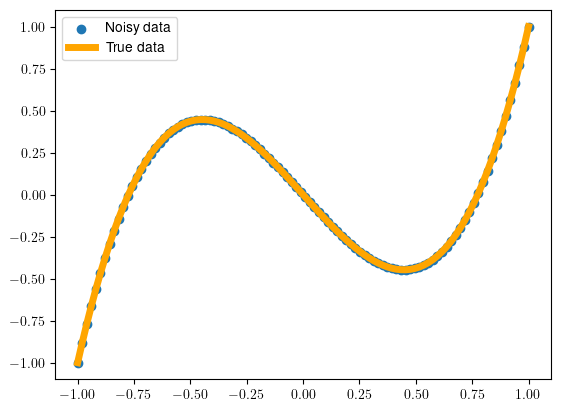

In [4]:
# Generate Data
x = np.linspace(-1, 1, 100)  # Input data
y_true = test_function(x) #np.sin(x)  # True function
std = 0.1
noise = np.random.normal(0, std, size=y_true.shape)  # Adding some noise

if add_noise:
  y_noisy = y_true + noise
else:
  y_noisy = y_true

_ = plt.scatter(x, y_noisy, label='Noisy data')
_ = plt.plot(x, y_true, linewidth=5, color='orange', label='True data')
_ = plt.legend()

The set of points generated above is the training set that we use to train our model, which is generated in the following cell:

In [ ]:
Model = PDFmodel(
          dense_layer='Dense',
          input=x,
          outputs=1,
          architecture=[25, 28],
          activations=['tanh', 'tanh']
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed,
          init_bias=False,
          dtype=np.float64)
Model.model.summary()
ntk = Model.compute_ntk()
f0 = Model.predict().numpy().squeeze()

Exception: The length of activations must match the number of layers.

In [18]:
from dlt.log import setup_logger

# Set up logger for notebook display
logger = setup_logger('dlt.model')

# Create a covariance matrix with the proper MultiIndex structure
# Create the identity matrix
if add_noise:
  cov_matrix = np.diag([std for _ in range(Ndat)])
else:
  cov_matrix = np.eye(len(x))

learning_rate = 1.e-3
epochs = 10000

# Create index with 'dataset' level as required by the function
arrays = [
        ["set" for _ in range(Ndat)],
        ["dataset" for _ in range(Ndat)],
    ]
multi_index = pd.MultiIndex.from_arrays(arrays, names=("group", "dataset"))

# Create DataFrame with proper MultiIndex structure
Cinv = pd.DataFrame(cov_matrix, index=multi_index, columns=multi_index)

# Create a simple FK table (identity matrix in this toy model case)
FK = np.eye(len(x))
FK_dict = {"dataset": FK}
data_dict = {"dataset": y_noisy}

# Generate the proper loss function
mse_loss = generate_mse_loss(Cinv)

# Train using the custom method instead of model.fit()
Model.train_network_gd(
    data=data_dict,
    FK_dict=FK_dict,
    loss_func=mse_loss,
    learning_rate=learning_rate,
    tol=0.0,
    logging=True,
    callback=True,
    max_epochs=epochs,
    optimizer="SGD"
)

Maximum number of iterations reached.


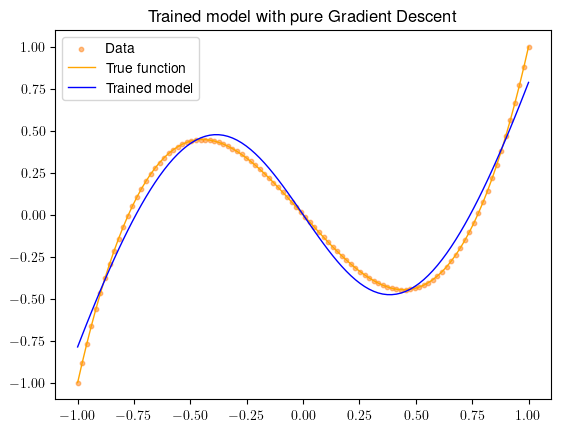

In [12]:
trained_predictions = Model.predict().numpy().squeeze()
_ = plt.scatter(x, y_noisy, label='Data', color='C1', alpha=0.5, s=10)
_ = plt.plot(x, y_true, linewidth=1, color='orange', label='True function')
_ = plt.plot(x, trained_predictions, linewidth=1, color='blue', label='Trained model')
_ = plt.legend()
_ = plt.title('Trained model with pure Gradient Descent')
_ = plt.show()

As explained in the paper, the flow equation can be integrated analytically at order $\mathcal{O}(1/n)$. Given a vector of targets $y$, the model prediction at time $t$ can be written as
$$
  T(t) = T(0) + \left( \mathbb{I} - e^{-\Theta \, \eta \, t} \right) \, (y - T(0)) \,,
$$
where $\Theta$ is the NTK, and $\eta$ is the learning rate. This expression can be evaluated if projected into the eigenspace of the NTK
$$
\Theta z^{(k)} = \lambda^{(k)} z^{(k)}
$$
$$
T(t) = \sum_{k=1}^{\textrm{eig}(\Theta)} \widetilde{T}_0^{(k)} \, v^{(k)} 
+ \sum_{k=1}^{\textrm{eig}(\Theta)} \left( 1 - e^{-\lambda^{(k)} \, \eta \, t} \right) \, (\widetilde{y}^{(k)} - \widetilde{T}_0^{(k)}) \, v^{(k)} \,,
$$
where $v^{(k)}$ is the $k$-th eigenvector relative to the eigenvalue $\lambda^{(k)}$ of the NTK. Quantities decorated with a tilde are the components in the NTK basis of the original vector, for instance
$$
\widetilde{T}_0^{(k)} = T(0) \cdot v^{(k)} \,.
$$
The function returns an array containing the different components and the relative eigenvector, as well as the sum of all components as shown in the equation above.

In [13]:
# Compute NTK decomposition
eigval, eigvec = np.linalg.eigh(ntk)
eigval = eigval[::-1]
eigvec = eigvec[:, ::-1]

r = 50

Lambda_perp = np.diag(eigval[:r])
Z_perp = eigvec[:, :r]
Z_par = eigvec[:, r:]

P_perp = Z_perp @ Z_perp.T
P_par = Z_par @ Z_par.T

f0_par = P_par @ f0
f0_perp = Z_perp.T @ f0

B = Lambda_perp @ ( -Z_perp.T @ Cinv @ Z_par @ Z_par.T @ f0 + Z_perp.T @ Cinv @ y_noisy)

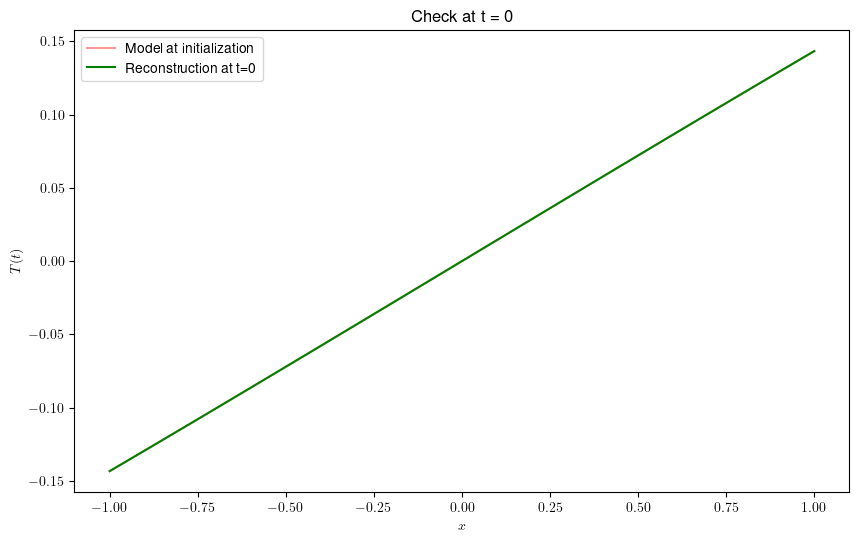

In [14]:
def analytical_solution(t):
  lam = np.diag(Lambda_perp)
  ft_perp = [np.exp(-t * lam[i]) * f0_perp[i] + (1 - np.exp(-lam[i] * t)) * B[i] / lam[i] for i in range(lam.size)]
  return Z_perp @ ft_perp + f0_par
    
# Simple check at initialization
init_reconstr = analytical_solution(0)

fig, ax = plt.subplots(figsize=(10,6))
_ = ax.plot(x, f0, label="Model at initialization", color='red', alpha=0.4)
_ = ax.plot(x, init_reconstr, color='green', label='Reconstruction at t=0')
ax.set_title(f"Check at t = 0")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$T(t)$')
_ = ax.legend()

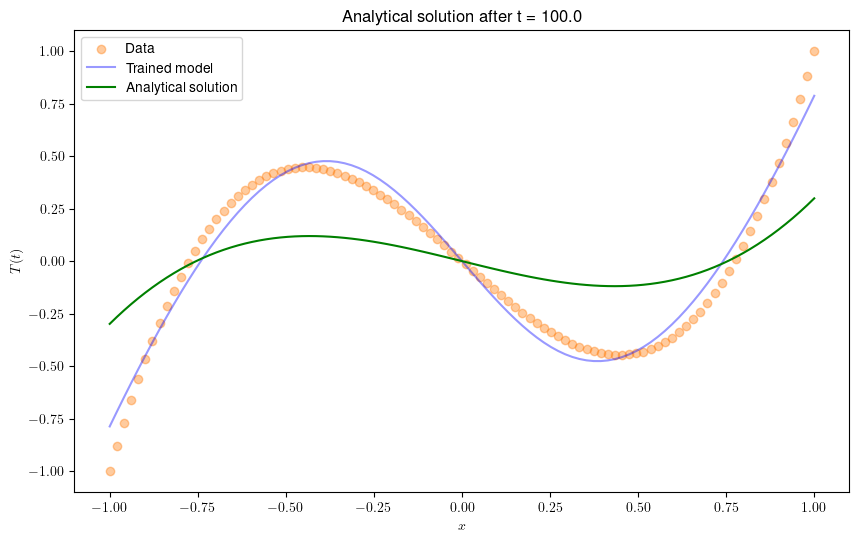

In [16]:
epochs = 1e5
t = epochs * learning_rate
T_t = analytical_solution(t)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y_noisy, label="Data", color='C1', alpha=0.4)
ax.plot(x, trained_predictions, label="Trained model", color='blue', alpha=0.4)
ax.plot(x, T_t, color='green', label='Analytical solution')
ax.set_title(f"Analytical solution after t = {t}")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$T(t)$')
ax.legend()

Comparison in function of the architecture

In [11]:
architectures = [
  [5],
  [10],
  [28],
  [100]
]

shift = 3
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,6), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
ax1.plot(x, y_noisy, label="True function", color='red')
ax2.plot(x, [1 for _ in range(x.size)], color='red')

for arch in architectures:
  Model = PDFmodel(
          dense_layer='Dense',
          input=x,
          outputs=1,
          architecture=architectures,
          activations=['tanh'],
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed,
          init_bias=False,
          dtype=np.float64)
Model.model.summary()
ntk = Model.compute_ntk()
f0 = Model.predict().numpy().squeeze()
  _, T_t = ntk_decomposition(t, model, x, learning_rate)
  ax1.plot(x, T_t, label=str(arch),  linestyle='dotted')
  ax2.plot(x, (T_t + shift) / (y_noisy + shift ),  linestyle='dotted')


ax1.set_title(f"Integrated solutions for different architectures at t = {t}")
ax2.set_xlabel(r'$x$')
ax1.set_ylabel(r'$T(t)$')
ax2.set_ylabel(r'Ratio to $y$')
ax1.legend()
plt.tight_layout()

IndentationError: unexpected indent (2013045770.py, line 28)